# Pre-flight checks

Import common modules, ensure MatplotLib plots figures inline, and prepare a function to save the figures.

In [2]:
import numpy as np
import os

# To make this notebook's output stable across runs

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "MNIST"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Load the data

Original MNIST, from kaggle datasets: https://www.kaggle.com/avnishnish/mnist-original

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
from scipy.io import loadmat

DATA_PATH = os.path.join("datasets", "MNIST")

def load_mnist_data(mnist_data_path=DATA_PATH):
    mat_path = os.path.join(mnist_data_path, "mnist-original.mat")
    return loadmat(mat_path)

mnist = load_mnist_data()
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

mnist_data, mnist_label

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([0., 0., 0., ..., 9., 9., 9.]))

In [5]:
X, y = mnist_data, mnist_label
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

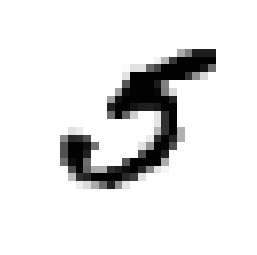

In [7]:
def display_digit(data=X, index=0):
    some_digit = data[index]
    some_digit_image = some_digit.reshape(28, 28)

    plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

some_digit_index = 36000
display_digit(index=some_digit_index)

In [8]:
y[some_digit_index]

5.0

In [9]:
num_train = 60000
X_train, X_test, y_train, y_test = X[:num_train], X[num_train:], y[:num_train], y[num_train:]

shuffle_index = np.random.permutation(num_train)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
X_train, y_train

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([1., 6., 6., ..., 0., 2., 9.]))

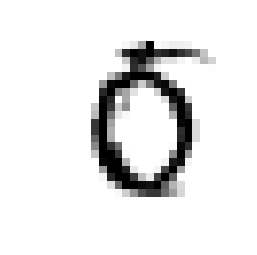

0.0

In [10]:
display_digit(data=X_train, index=some_digit_index)
y_train[some_digit_index]

In [11]:
def plot_images_sample(X=X_train, y=y_train):
    # Draw plot for images sample
    
    plt.figure(figsize=(10,10))
    rand_indices = np.random.randint(len(X), size=25)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = rand_indices[i]
        image = X[index].reshape(28, 28)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y[index])
    plt.show()

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [13]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

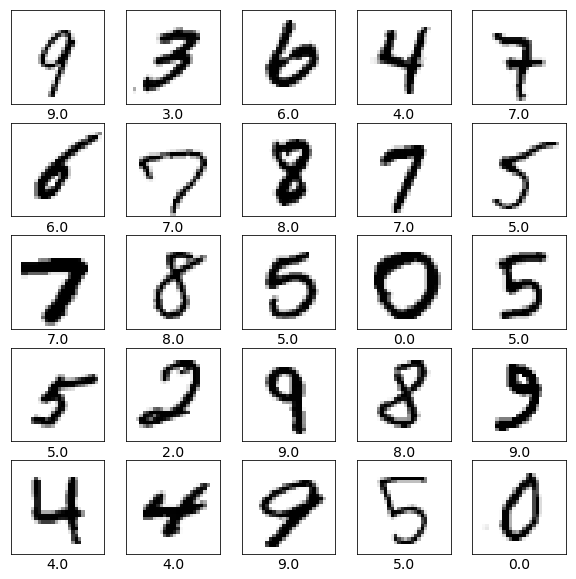

In [14]:
plot_images_sample()

# Train a Binary Classifier

Train a model to detect two calsses: '5 || !5'

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## SGDClassifier

In [16]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd.predict([X[some_digit_index]])

array([ True])

In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="precision")

array([0.94334764, 0.81807442, 0.93590734])

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54122,   457],
       [ 1725,  3696]], dtype=int64)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_train_pred)

0.8899590657356128

In [22]:
recall_score(y_train_5, y_train_pred)

0.6817930271167681

In [23]:
f1_score(y_train_5, y_train_pred)

0.7720910800083559

## Precision/Recall Tradeoff

In [24]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

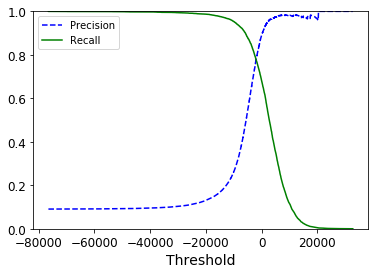

In [27]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

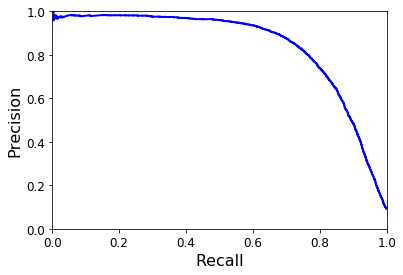

In [29]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

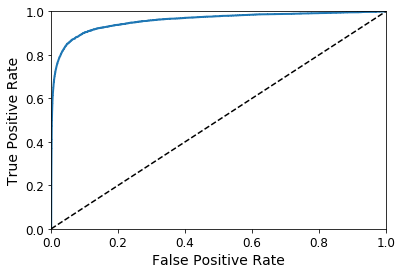

In [32]:
plot_roc_curve(fpr, tpr)
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9577210519742373

## RandomForestClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest

array([[1.  , 0.  ],
       [0.98, 0.02],
       [1.  , 0.  ],
       ...,
       [0.99, 0.01],
       [0.98, 0.02],
       [1.  , 0.  ]])

In [35]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0.  , 0.02, 0.  , ..., 0.01, 0.02, 0.  ])

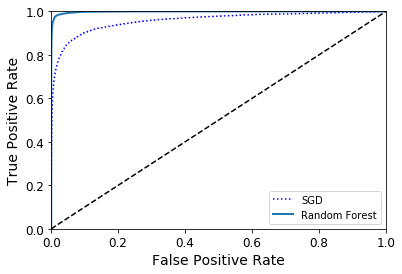

In [36]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983730844244434

In [38]:
y_pred_forest = cross_val_predict(forest, X_train, y_train_5, cv=3)
y_pred_forest

KeyboardInterrupt: 

In [ ]:
precision_score(y_train_5, y_pred_forest)

In [ ]:
recall_score(y_train_5, y_pred_forest)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train_5, y_pred_forest)

### Train multiclass (single output) on whole data / labels

In [ ]:
cross_val_score(forest, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
y_train_pred = cross_val_predict(forest, X_train, y_train, cv=3)

In [ ]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

#### Show the confusion matrix for normalized errors (num err / total instances)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Note: 4 -> 9 | 3 -> 2 | 9 -> 3 | 5 -> 3 are the worst

In [ ]:
def real_vs_predicted_arr(real_idx, predicted_idx, X=X_train):
    return X[(y_train == real_idx) & (y_train_pred == predicted_idx)]

def subplot_arr(X, subplot_no):
    plt.subplot(subplot_no); plot_digits(X[:25], images_per_row=5)

In [ ]:
X_49 = real_vs_predicted_arr(4, 9)
X_32 = real_vs_predicted_arr(3, 2)
X_93 = real_vs_predicted_arr(9, 3)
X_53 = real_vs_predicted_arr(5, 3)

plt.figure(figsize=(8,8))
subplot_arr(X_49, 221)
subplot_arr(X_32, 222)
subplot_arr(X_93, 223)
subplot_arr(X_53, 224)
plt.show()

In [ ]:
from scipy.ndimage.interpolation import shift

def expand_training_set(X, y):
    expanded_X = X.copy()
    expanded_y = y.copy()
    for idx, val in enumerate(X):
        y_val = y[idx]
        down = shift(val, [28], cval=0)
        expanded_X = np.append(expanded_X, [down], axis=0)
        expanded_y = np.append(expanded_y, y_val)
        up = shift(val, [-28], cval=0)
        expanded_X = np.append(expanded_X, [up], axis=0)
        expanded_y = np.append(expanded_y, y_val)
        left = shift(val, [-1], cval=0)
        expanded_X = np.append(expanded_X, [left], axis=0)
        expanded_y = np.append(expanded_y, y_val)
        right = shift(val, [1], cval=0)
        expanded_X = np.append(expanded_X, [right], axis=0)
        expanded_y = np.append(expanded_y, y_val)
        if (idx % 1000 == 0):
            print(f'{idx} images processed')
        
    return expanded_X, expanded_y

In [84]:
expanded_X, expanded_y = expand_training_set(X_train, y_train)
expanded_X.shape, expanded_y.shape

0 images processed
1000 images processed
2000 images processed
3000 images processed
4000 images processed
5000 images processed
6000 images processed
7000 images processed
8000 images processed
9000 images processed
10000 images processed
11000 images processed
12000 images processed
13000 images processed
14000 images processed
15000 images processed
16000 images processed
17000 images processed
18000 images processed
19000 images processed
20000 images processed
21000 images processed
22000 images processed
23000 images processed
24000 images processed
25000 images processed
26000 images processed
27000 images processed
28000 images processed
29000 images processed
30000 images processed
31000 images processed
32000 images processed
33000 images processed
34000 images processed
35000 images processed
36000 images processed
37000 images processed
38000 images processed
39000 images processed
40000 images processed
41000 images processed
42000 images processed
43000 images processed
4

((300000, 784), (300000,))

### Check output

array([6., 6., 6., 6., 8., 8., 8., 8., 3., 3., 3., 3., 4., 4., 4., 4., 2.,
       2., 2., 2., 5., 5., 5., 5., 2.])

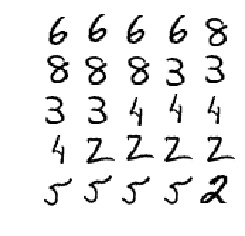

In [110]:
plt.figure(figsize=(8,8))
sub = expanded_X[150000:]
subplot_arr(sub, 221)
expanded_y[150000:150025]

Output OK. Images are shifted without warping, and the labels match.

### Save the arrays

In [118]:
import pandas as pd

df = pd.DataFrame(expanded_X)
df["label"] = expanded_y

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Columns: 785 entries, 0 to label
dtypes: float64(1), uint8(784)
memory usage: 226.6 MB


In [120]:
path = os.path.join(DATA_PATH, "expanded_dataset.csv")
df.to_csv(path)

### Load expanded DataFrames

In [49]:
import pandas as pd

path = os.path.join(DATA_PATH, "expanded_dataset.csv")
df = pd.read_csv(path, index_col=False)
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [50]:
df.reset_index(drop=True, inplace=True)
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [51]:
y_expanded = df["label"]
y_expanded.shape

(300000,)

In [52]:
X_expanded = df.drop(columns="label")
X_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Columns: 785 entries, Unnamed: 0 to 783
dtypes: int64(785)
memory usage: 1.8 GB


In [57]:
X_expanded = X_expanded.to_numpy()
X_expanded.shape

(300000, 785)

In [58]:
X_ex = np.delete(X_ex, 0, 1)
X_ex.shape

MemoryError: Unable to allocate 1.75 GiB for an array with shape (300000, 784) and data type int64

In [1]:
num_train = 300000

shuffle_index = np.random.permutation(num_train)
X_train_expanded, y_train_expanded = X_ex[shuffle_index], expanded_y[shuffle_index]
X_train_expanded, y_train_expanded

NameError: name 'np' is not defined